In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import json
#import folium

# Est-ce que le sommet est visible ?


data: https://earthexplorer.usgs.gov/  

georaster:  https://pypi.python.org/pypi/georasters/  

gdal install in virtual env:
https://stackoverflow.com/questions/32066828/install-gdal-in-virtualenvwrapper-environment

http://sherrytowers.com/2014/04/13/archeoastronomy-calculating-the-horizon-profile-using-online-us-geographic-survey-data/


In [2]:
#import georasters as gr

In [3]:
from osgeo import gdal

In [137]:
#filename = 'elevation_data/n45_e005_1arc_v3.tif'
filename = 'elevation_data/merged_3arc.tif'

filename = 'elevation_data/viewfinderdata/merged_1arc.hgt'  # http://www.viewfinderpanoramas.org/dem3.html#alps

In [138]:
dataset = gdal.Open(filename)

In [139]:
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()


In [140]:
elevation = band.ReadAsArray()

print(elevation.shape)
print( elevation )

(7201, 7201)
[[ 280  280  280 ..., 3142 3149 3161]
 [ 280  280  280 ..., 3151 3159 3168]
 [ 280  280  280 ..., 3165 3173 3181]
 ..., 
 [  41   42   42 ...,  824  812  800]
 [  41   42   42 ...,  804  794  780]
 [  41   42   42 ...,  787  777  765]]


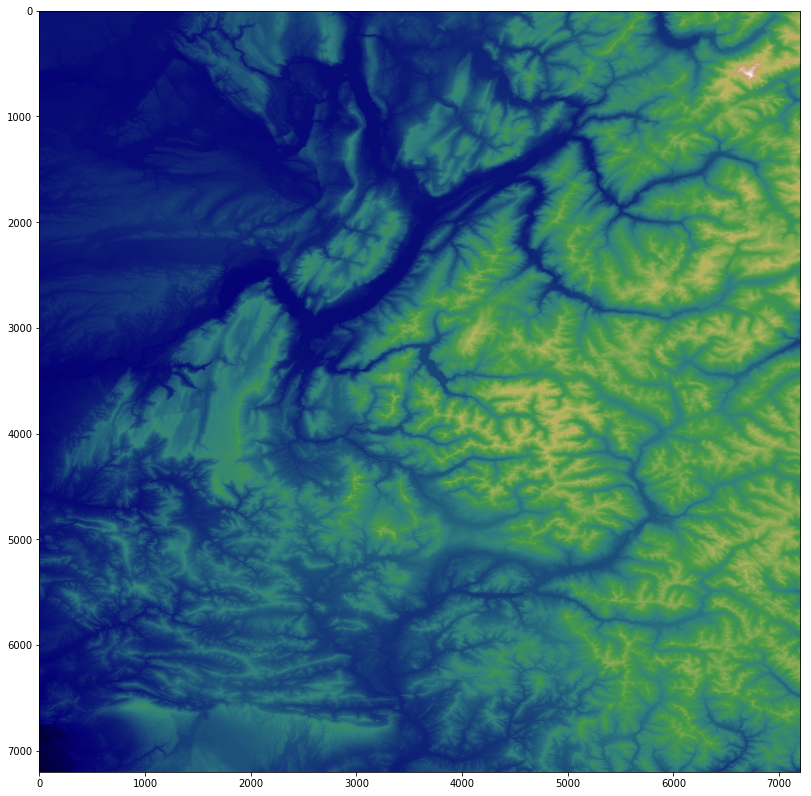

In [141]:
plt.figure( figsize=(14, 14))
plt.imshow(elevation, cmap='gist_earth')
plt.show()

In [142]:
elevation.max()

4801

In [27]:
projection = dataset.GetProjection()

In [28]:
projection

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [32]:
transf = dataset.GetGeoTransform()
transfInv = gdal.InvGeoTransform(transf)

In [33]:
lon, lat = 5.7103223, 45.1973288

In [34]:
px, py = gdal.ApplyGeoTransform(transfInv, lon, lat)

In [36]:
px, py

(852.8867599999994, 963.7054399999906)

In [43]:
montblanc =  6.858996564, 45.833496666

In [44]:
montblanc_pxy = gdal.ApplyGeoTransform(transfInv, *montblanc)

In [49]:
montblanc_pxy = [ int( u ) for u in montblanc_pxy ]

In [76]:
montblanc_latlon = gdal.ApplyGeoTransform(transf, *montblanc_pxy)

In [77]:
montblanc_latlon

[6.858750000000001, 45.83375]

In [65]:
elevation[ montblanc_pxy[1]+42, montblanc_pxy[0]+48 ]

0

In [66]:
flat_i = np.argmax( elevation )
np.unravel_index(flat_i, elevation.shape )

(199, 2238)

In [61]:
montblanc_pxy

[2231, 200]

In [67]:
structval = band.ReadRaster(int(montblanc_pxy[0]), int(montblanc_pxy[1]), 1,1, buf_type = band.DataType )

In [68]:
structval

b'\x00\x00'

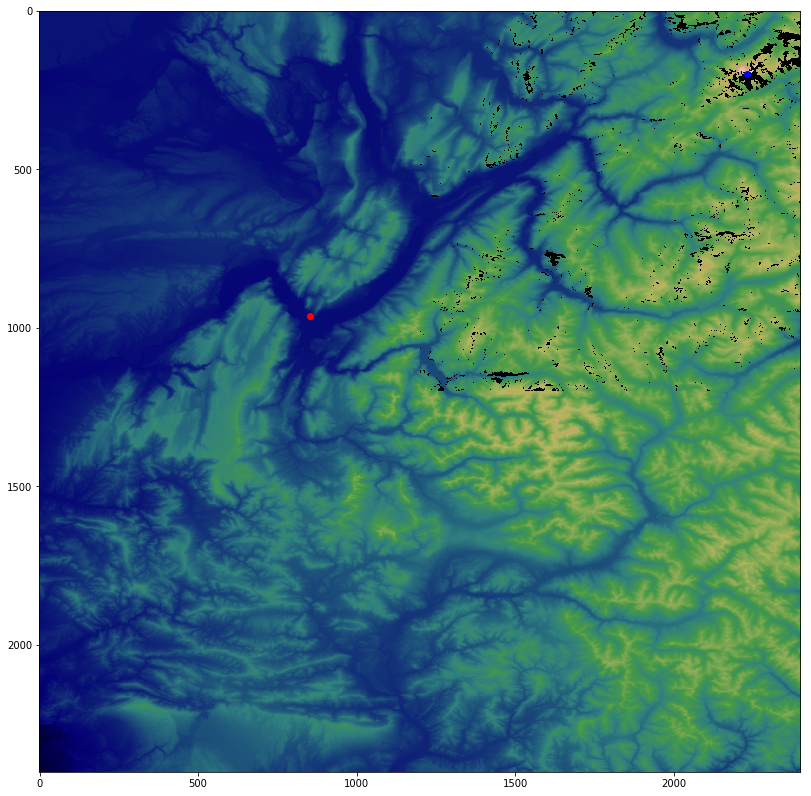

In [57]:
plt.figure( figsize=(14, 14))
plt.imshow(elevation, cmap='gist_earth')

plt.plot(px, py , 'or' )
plt.plot(*montblanc_pxy , 'ob' )
plt.show()

## Distance de l'horizon

In [70]:
R = 6371.009 # km

In [72]:
d_horizon = lambda z: R*np.arcsin( 1e3*z/(R+z*1e3) )

In [74]:
d_horizon( 200 )

8420.3758575723659

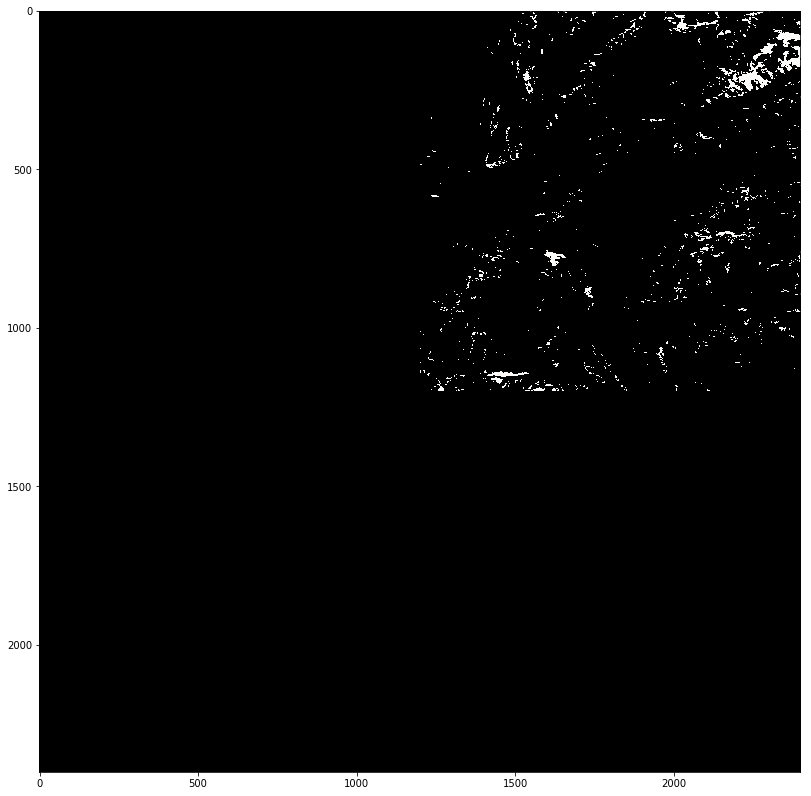

In [78]:
plt.figure( figsize=(14, 14))
plt.imshow(elevation==0, cmap='gist_earth')

In [79]:
0.000145444104333*R

0.926625697702482

# Get the profil

In [169]:
R = 6371.009 # km, rayon moyen de la terre


In [261]:
#coordsA = (5.7103223, 45.1973288) # gre
coordsA = ( 5.639419, 45.147507 ) # Moucherotte
coordsB = (6.858996564, 45.833496666) # Mont Blanc

In [262]:
transf = dataset.GetGeoTransform()
transfInv = gdal.InvGeoTransform(transf)

def to_px( coords ):
    px = gdal.ApplyGeoTransform(transfInv, *coords)
    return [ int( x ) for x in px ]

def to_deg( pxy ):
    return gdal.ApplyGeoTransform(transf, *pxy )

In [263]:
px = to_px( coordsA )

In [264]:
to_deg( px )

[5.639305555555556, 45.14763888888889]

In [265]:
pxA, pxB = to_px( coordsA ), to_px( coordsB )

In [266]:
# distance entre A et B en pixel
L = np.sqrt( (pxA[0]-pxB[0])**2 +  (pxA[1]-pxB[1])**2  )

In [267]:
# nombre de points 
N = int( np.floor( L/3 ) )
print( N )

1679


In [268]:
elevation = band.ReadAsArray()

def get_ele( xy ):
    return elevation[ xy[1] , xy[0] ]

In [269]:
def torad( theta ):
    return theta * np.pi / 180.0

In [270]:
# angle entre deux positions sur terre
def get_theta( lon1, lat1, lon2, lat2 ):
    lat1, lon1, lat2, lon2 = [ torad(theta) for theta in [lat1, lon1, lat2, lon2] ]
    cosTheta =  np.sin( lat1 )*np.sin( lat2 ) + np.cos( lat1 )*np.cos( lat2 )*np.cos( lon2-lon1 )
    
    cosTheta = np.array( cosTheta )
    cosTheta[ cosTheta> 1 ] = 1  # debug .... cas si lat1==lat2 et lon1 == lon2
    
    theta = np.arccos( cosTheta )
    
    return theta # en rad

In [271]:
def get_dip_angle( eleA, eleB, thetaAB ):
    a, b = eleA+R, eleB+R
    
    cosGamma = b*np.sin( thetaAB )/np.sqrt( a**2 + b**2 * 2*a*b*np.cos(thetaAB) )
    
    return np.arccos( cosGamma )*180/np.pi

def get_dip_angle_flat( eleA, eleB, thetaAB ):
 
    pente = (eleB - eleA)/( thetaAB*R/1e3 )
    
    return pente*180/np.pi

In [272]:
x_span = np.linspace( pxA[0], pxB[0], N )
y_span = np.linspace( pxA[1], pxB[1], N )

pxy_span = [ (int(xy[0]), int(xy[1])) for xy in np.array( [ x_span, y_span ] ).T ]
ele_span = [ get_ele( pxy ) for pxy in pxy_span ]
deg_span = [ to_deg( pxy ) for pxy in pxy_span ]

theta_span = [ get_theta( *coordsA, *deg ) for deg in deg_span ]


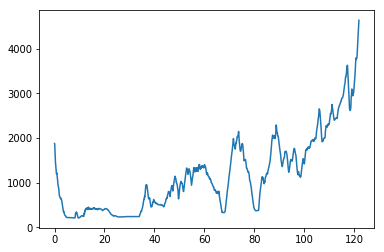

In [273]:
plt.plot( R*np.array( theta_span), ele_span )

In [274]:
# prise en compte courbure de la Terre
delta_ele = R*( 1- np.cos(theta_span[-1] / 2)/np.cos(theta_span - theta_span[-1] / 2) )*1e3

elevation_vue = np.array( ele_span )  + delta_ele

x = R*np.array( theta_span)
y = elevation_vue
ligne_de_vue = x*(y[-1]-y[0])/(x[-1]-x[0]) + y[0]

# test si visible

visible = ((ligne_de_vue - elevation_vue) > 0 ).all()

In [275]:
visible

True

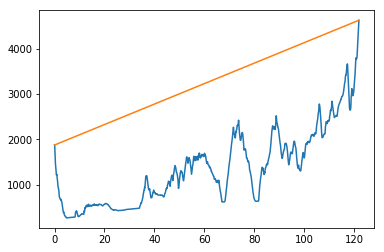

In [276]:
plt.plot( R*np.array( theta_span), elevation_vue )
plt.plot( R*np.array( theta_span), ligne_de_vue )

In [228]:
R*( 1/np.cos(theta) - 1 )*1e3

784.88561501530535